# Block 5 Exercise 2: Predicting the fare of taxi rides
Using the NY Taxi data set (see Use Case Block I) and the use case from the lecture...

In [76]:
import pandas as pd
import numpy as np
import folium


In [77]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


In [78]:
# we load the data we have saved after wrangling and pre-processing in block I
X=pd.read_csv(path+'/DATA/train_cleaned.csv')
drop_columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','key','pickup_datetime','pickup_date','pickup_latitude_round3','pickup_longitude_round3','dropoff_latitude_round3','dropoff_longitude_round3']
X=X.drop(drop_columns,axis=1)
X=pd.get_dummies(X)# one hot coding
#generate labels
y=X['fare_amount']
X=X.drop(['fare_amount'],axis=1)

In [79]:
# a quick look at the data
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,...,pickup_borough_manhattan,pickup_borough_others,pickup_borough_queens,pickup_borough_staten_island,dropoff_borough_bronx,dropoff_borough_brooklyn,dropoff_borough_manhattan,dropoff_borough_others,dropoff_borough_queens,dropoff_borough_staten_island
0,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009,...,0,0,1,0,0,0,0,0,1,0
1,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010,...,1,0,0,0,0,0,1,0,0,0
2,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011,...,1,0,0,0,0,0,1,0,0,0
3,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012,...,1,0,0,0,0,0,1,0,0,0
4,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010,...,1,0,0,0,0,0,1,0,0,0


In [80]:
y.head()

0     4.5
1    16.9
2     5.7
3     7.7
4     5.3
Name: fare_amount, dtype: float64

### E 2.1 Split data into train and test data
* use data from 2009-1014 for training and 2015 for evaluation


In [81]:
# train data: 
X_train=X[X['pickup_year']<2015]
y_train=y[X['pickup_year']<2015]
# test data:
X_test=X[X['pickup_year']==2015]
y_test=y[X['pickup_year']==2015]

### E 2.2 Train a Random Forest Regression Model
* train model using [RF regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
* optimize the model parameters (#trees, depth, vars per split, ...) and evaluate the [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) on train and test data
* Analyze the model error: are there typical settings where the model fails?

In [82]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_jobs=-1)

In [83]:
%%time
rf.fit(X_train,y_train)

Wall time: 58.4 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [84]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_train,rf.predict(X_train)))
print(mean_squared_error(y_test,rf.predict(X_test)))

2.3970231394937676
21.20278831616064


MSE on test data is very high
so use some other metrics to analyze the error

In [85]:
from sklearn.metrics import max_error
print(max_error(y_train,rf.predict(X_train)))
print(max_error(y_test,rf.predict(X_test)))

181.78499999999997
434.2366


max_error is higher, so there is an outlier

In [86]:
from sklearn.metrics import explained_variance_score
print(explained_variance_score(y_train,rf.predict(X_train)))
print(explained_variance_score(y_test,rf.predict(X_test)))

0.9742133956527622
0.8386472097704406


let's check the actual errors

In [114]:
errors = np.abs(y_test - rf.predict(X_test))

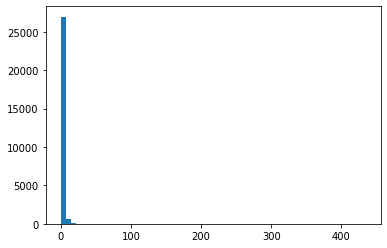

In [88]:
import matplotlib.pyplot as plt
_ = plt.hist(errors, bins=60)

everything, very close to zero, so there are clearly outliers
let's search for the outliers:

In [135]:
outliers = X_test[errors>25]
print(np.shape(outliers))
outliers = np.array(outliers)

(83, 31)


In [139]:
#show outliers on map
outlier_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12,)
for i in range (np.shape(outliers)[0]):
    folium.CircleMarker([outliers[i,1], outliers[i,0]], radius=3,                
                        color="green", 
                        fill_opacity=0.9
                       ).add_to(outlier_map)
    folium.CircleMarker([outliers[i,3], outliers[i,2]], radius=3,                
                        color="red", 
                        fill_opacity=0.9
                       ).add_to(outlier_map)
    
outlier_map